In [1]:
import numpy as np
import ldpc.codes
from ldpc.bplsd_decoder import BpLsdDecoder

H = ldpc.codes.hamming_code(5)

bp_osd = BpLsdDecoder(
    H,
    error_rate=0.1,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="lsd_cs",
    lsd_order=2,
)

syndrome = np.random.randint(size=H.shape[0], low=0, high=2).astype(np.uint8)

print(f"Syndrome: {syndrome}")
decoding = bp_osd.decode(syndrome)
print(f"Decoding: {decoding}")
decoding_syndrome = H @ decoding % 2
print(f"Decoding syndrome: {decoding_syndrome}")

Syndrome: [1 1 1 0 1]
Decoding: [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoding syndrome: [1 1 1 0 1]


# BB code (bit-flip)

In [2]:
from qldpc import codes
from sympy.abc import x, y

# second-to-last code in Table 3: [[n, k, d]] = [[360, 12, <=24]]
dims = {x: 12, y: 6}
terms_a = x**9 + y + y**2
terms_b = y**3 + x**25 + x**26
bicycle_code = codes.BBCode(dims, terms_a, terms_b)

print("number of physical qubits:", bicycle_code.num_qubits)
print("number of logical qubits:", bicycle_code.dimension)

number of physical qubits: 144
number of logical qubits: 12


In [227]:
H = np.array(bicycle_code.matrix_z)
bplsd = BpLsdDecoder(
    H,
    error_rate=1e-2,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="lsd_cs",
    lsd_order=0,
)
bplsd.set_do_stats(True)

In [296]:
sum(error)

12

In [297]:
sum(syndrome)

28

In [295]:
p = 6e-2
error = np.random.choice([0, 1], size=H.shape[1], p=[1 - p, p])
error = error.astype(np.uint8)
syndrome = error @ (H.T) % 2
pred = bplsd.decode(syndrome)
print(np.all(pred @ (H.T) % 2 == syndrome))
stats = bplsd.statistics["individual_cluster_stats"]
for cluster, data in stats.items():
    if data["active"]:
        print(cluster, data["final_bit_count"])

True
16 61


In [304]:
stats[16]

{'final_bit_count': 61,
 'undergone_growth_steps': 40,
 'nr_merges': 11,
 'active': True,
 'size_history': [10,
  11,
  12,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61],
 'got_valid_in_timestep': 39,
 'got_inactive_in_timestep': -1,
 'absorbed_by_cluster': -1,
 'nr_of_non_zero_check_matrix_entries': 183,
 'cluster_pcm_sparsity': 0.9538461538461538,
 'solution': [1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1]}

# BB Code (circuit-level)

In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from tqdm import tqdm

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

# Other modules (if needed)
from src.ldpc_post_selection import *

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

# Cluster ratio vs Detector density

In [8]:
def read_df(n):
    d_dict = {72: 6, 108: 10, 144: 12, 288: 18}
    d = d_dict[n]
    path = f"data/BB_circuit_lsd7_n{n}_d{d}"
    return pd.read_pickle(path)

<Axes: xlabel='cluster_ratio', ylabel='det_density'>

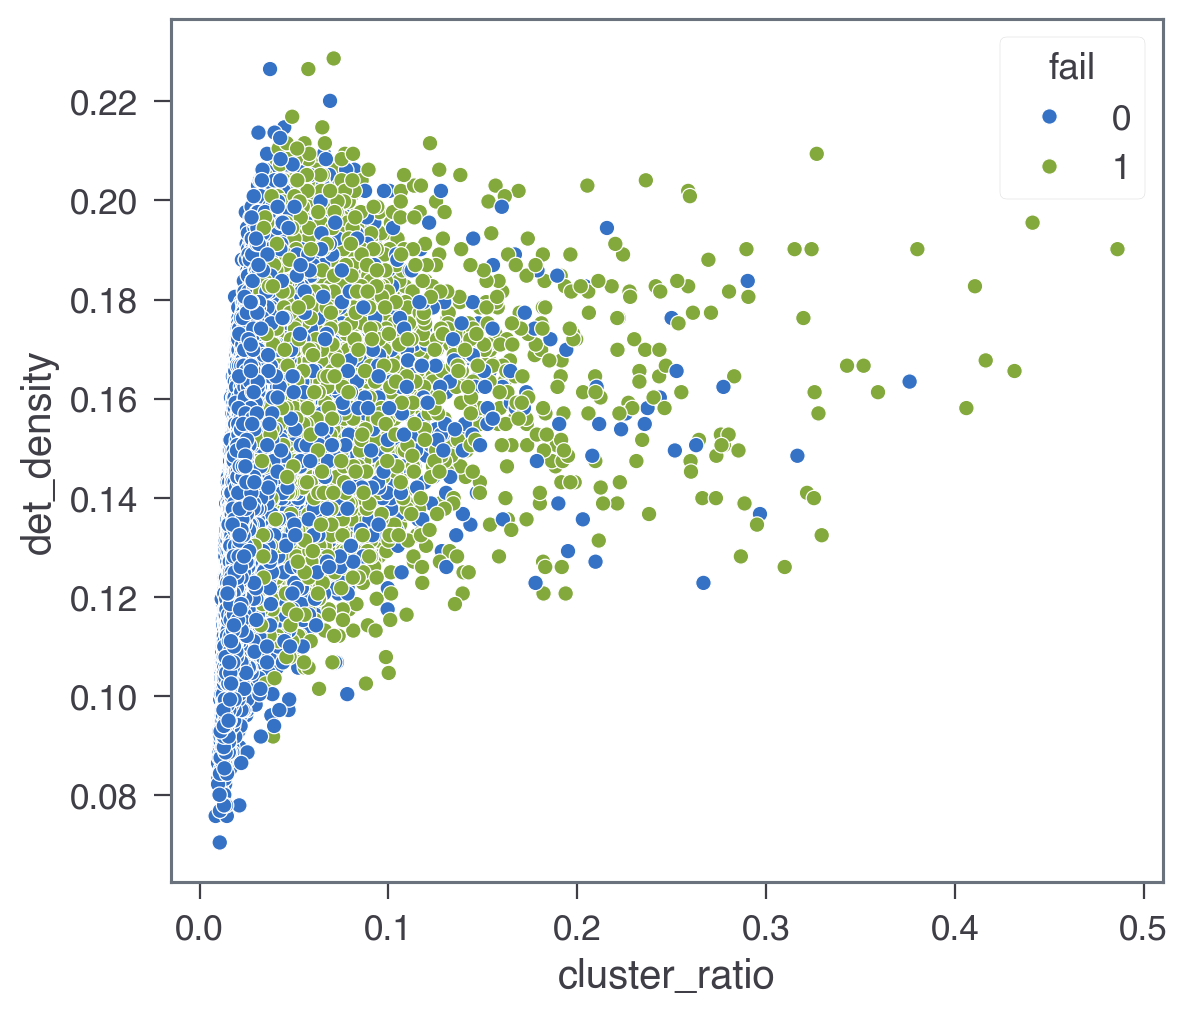

In [10]:
import seaborn as sns

df = read_df(144)
sns.scatterplot(df[(df["p"] == 0.005)], x="cluster_ratio", y="det_density", hue="fail")

/Users/slee7208/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a


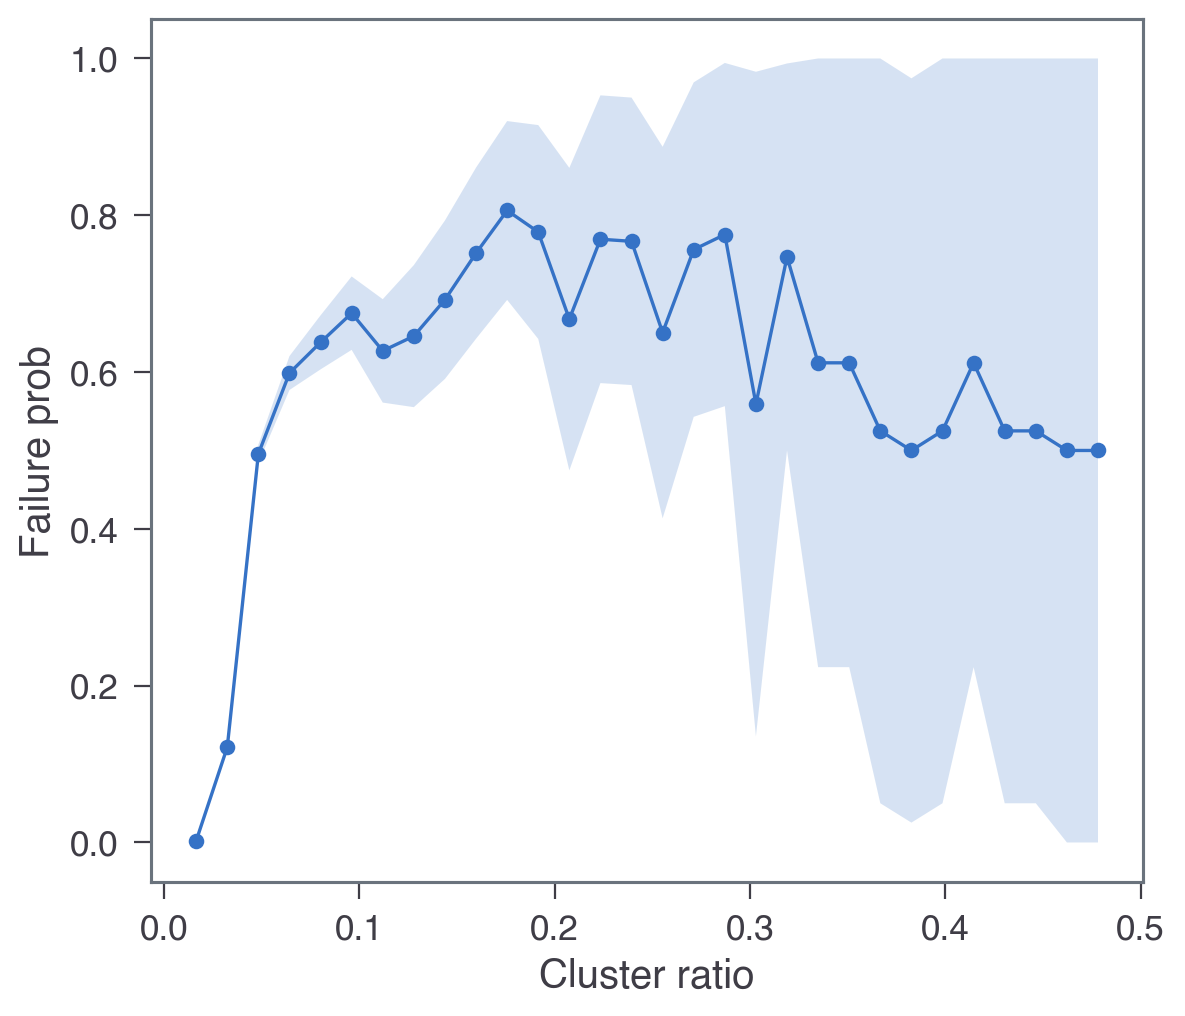

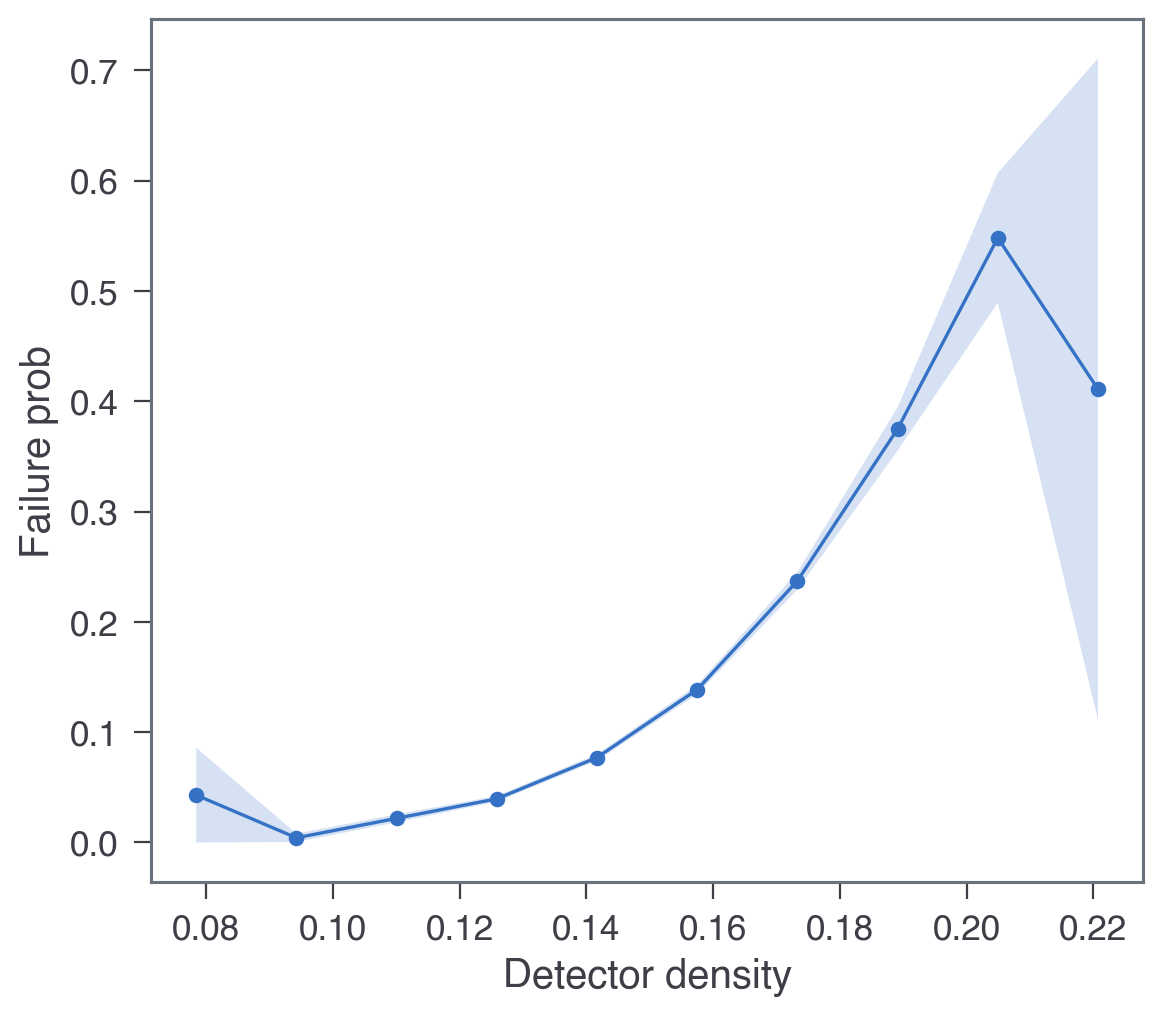

In [12]:
df = read_df(144)
df = df[(df["p"] == 0.005)]

cr = df["cluster_ratio"]
dd = df["det_density"]

xs = np.linspace(min(cr), max(cr), 31)
pfails = []
pfails_low = []
pfails_upp = []
for i_x in range(len(xs) - 1):
    df_partial = df[(cr >= xs[i_x]) & (cr < xs[i_x + 1])]
    pfail_low, pfail_upp = proportion_confint(
        df_partial["fail"].sum(), len(df_partial), alpha=0.05, method="binom_test"
    )
    pfail = (pfail_low + pfail_upp) / 2
    pfails.append(pfail)
    pfails_low.append(pfail_low)
    pfails_upp.append(pfail_upp)

xs_mid = (xs[:-1] + xs[1:]) / 2
plt.plot(xs_mid, pfails, "o-")
plt.fill_between(xs_mid, pfails_low, pfails_upp, alpha=0.2)
plt.xlabel("Cluster ratio")
plt.ylabel("Failure prob")
plt.show()

xs = np.linspace(min(dd), max(dd), 11)
pfails = []
pfails_low = []
pfails_upp = []
for i_x in range(len(xs) - 1):
    df_partial = df[(dd >= xs[i_x]) & (dd < xs[i_x + 1])]
    pfail_low, pfail_upp = proportion_confint(
        df_partial["fail"].sum(), len(df_partial), alpha=0.05, method="binom_test"
    )
    pfail = (pfail_low + pfail_upp) / 2
    pfails.append(pfail)
    pfails_low.append(pfail_low)
    pfails_upp.append(pfail_upp)

xs_mid = (xs[:-1] + xs[1:]) / 2
plt.plot(xs_mid, pfails, "o-")
plt.fill_between(xs_mid, pfails_low, pfails_upp, alpha=0.2)
plt.xlabel("Detector density")
plt.ylabel("Failure prob")
plt.show()

In [14]:
cr = df["cluster_ratio"]
cr_mean, cr_std = cr.mean(), cr.std()
cr_succ_mean, cr_fail_mean = (
    df[df["fail"] == i]["cluster_ratio"].mean() for i in range(2)
)
print((cr_fail_mean - cr_succ_mean) / cr_std)

dd = df["det_density"]
dd_mean, dd_std = dd.mean(), dd.std()
dd_succ_mean, dd_fail_mean = (
    df[df["fail"] == i]["det_density"].mean() for i in range(2)
)
print((dd_fail_mean - dd_succ_mean) / dd_std)

1.5315852559931826
0.7928640067309493


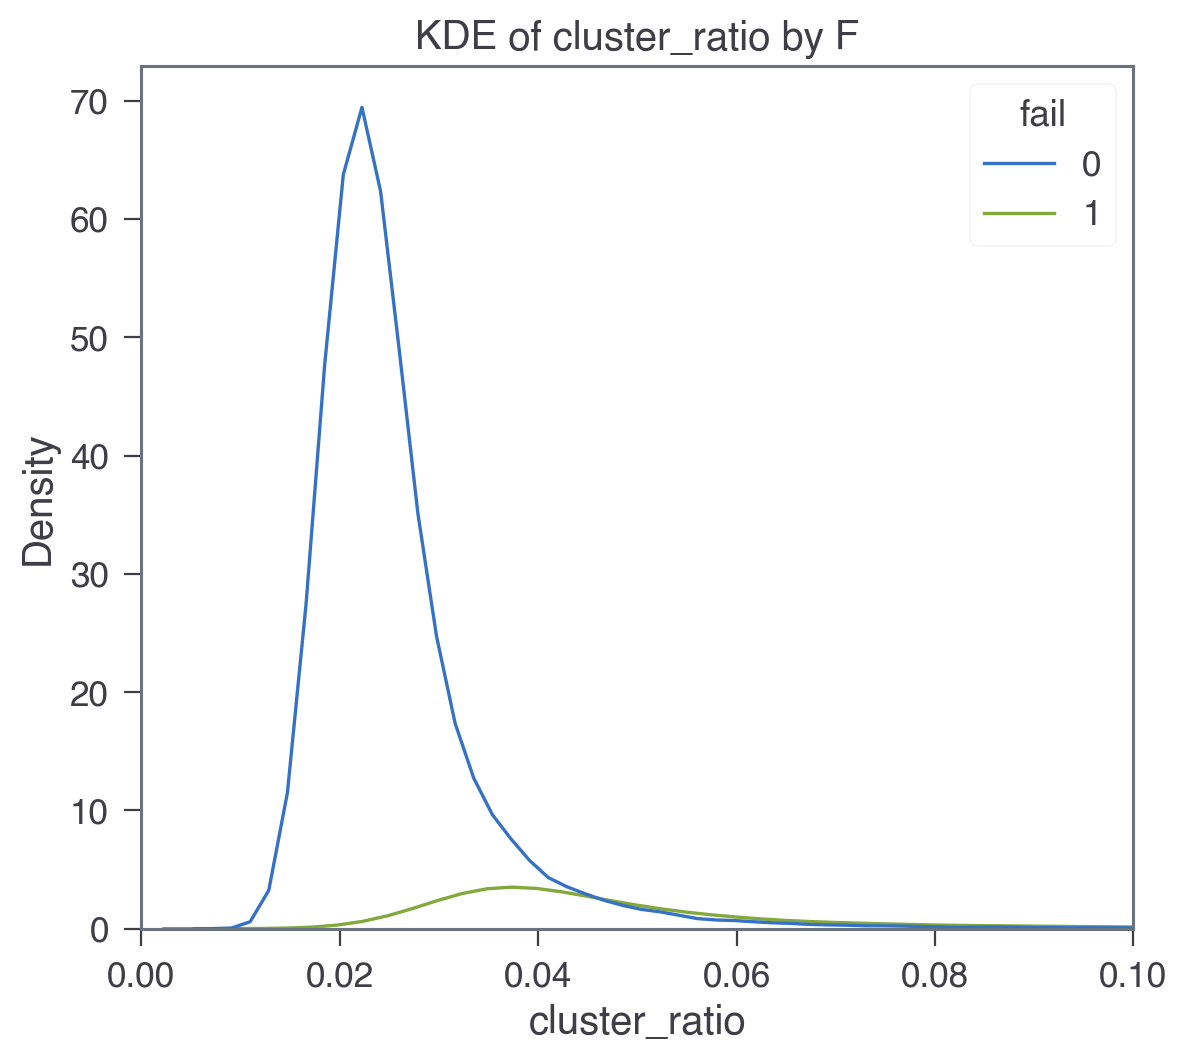

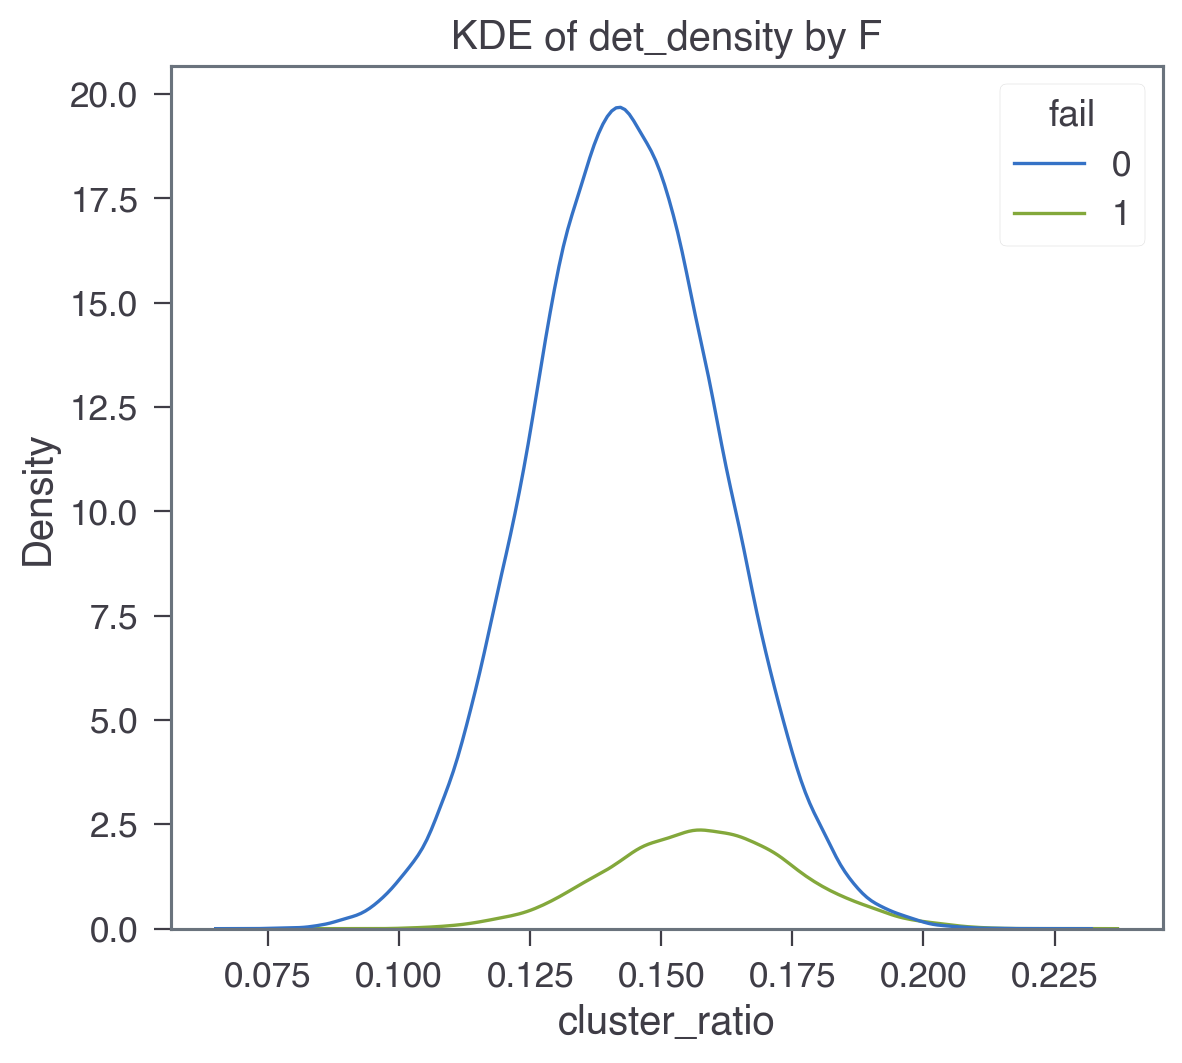

In [19]:
import seaborn as sns
from scipy.stats import iqr as compute_iqr

df = read_df(144)
df = df[(df["p"] == 0.005)]

# KDE for cluster ratio
sns.kdeplot(df, x="cluster_ratio", hue="fail", bw_adjust=1)
plt.xlabel("cluster_ratio")
plt.title("KDE of cluster_ratio by F")
plt.xlim(0, 0.1)
plt.show()

# KDE for det density
sns.kdeplot(df, x="det_density", hue="fail", bw_adjust=1)
plt.xlabel("cluster_ratio")
plt.title("KDE of det_density by F")
plt.show()

# Failure & abort rates

In [22]:
nlist = [72, 108, 144, 288]
for n in nlist:
    df = read_df(n)
    cr_min = df["cluster_ratio"].min()
    cr_mean = df["cluster_ratio"].mean()
    cr_max = df["cluster_ratio"].max()
    print(n, cr_min, cr_mean, cr_max)
    del df

72 0.0 0.03162043707686181 0.5371863799283154
108 0.0005446623093681918 0.042392525619301215 0.6786492374727668
144 0.0012522768670309653 0.04758133867132158 0.6629098360655737
288 0.00393009768009768 0.055295756400717364 0.7668650793650794


In [40]:
cols = [
    "c",
    "n",
    "p",
    "fail",
    "fail_low",
    "fail_upp",
    "abort",
    "abort_low",
    "abort_upp",
]
df_PS = pd.DataFrame(columns=cols, dtype="float64")

In [43]:
from statsmodels.stats.proportion import proportion_confint
import pandas as pd
import numpy as np
from tqdm import tqdm

clist = np.arange(0.9, 1.0001, 0.001).round(decimals=6)
clist = np.concatenate([np.array([0.0]), clist])

for n in nlist:
    print(f"n={n}")
    df = read_df(n)
    plist = np.sort(df["p"].unique())
    for p in tqdm(plist):
        df_p = df[df["p"] == p]
        df_p = df_p.sort_values("cluster_ratio", axis=0)
        df_p["cum_num_fail"] = df_p["fail"].cumsum()
        num_samples = df_p.shape[0]
        df_p.index = np.arange(1, num_samples + 1)
        org_cols = df_p.columns

        inds = (
            np.searchsorted(df_p["cluster_ratio"].values, 1 - clist, side="right") - 1
        )
        mask_valid_inds = inds != -1
        inds = inds[mask_valid_inds]
        clist_valid = clist[mask_valid_inds]

        df_p_selected = df_p.iloc[inds]
        del df_p
        df_p_selected["c"] = clist_valid

        fail_low, fail_upp = proportion_confint(
            df_p_selected["cum_num_fail"].values,
            df_p_selected.index,
            alpha=0.05,
            method="binom_test",
        )
        fail = (fail_low + fail_upp) / 2
        abort_low, abort_upp = proportion_confint(
            num_samples - df_p_selected.index,
            num_samples,
            alpha=0.05,
            method="binom_test",
        )
        abort = (abort_low + abort_upp) / 2

        for col in org_cols:
            if col not in cols:
                del df_p_selected[col]

        new_cols = ["fail", "fail_low", "fail_upp", "abort", "abort_low", "abort_upp"]
        new_vals = [fail, fail_low, fail_upp, abort, abort_low, abort_upp]
        for col, val in zip(new_cols, new_vals):
            df_p_selected[col] = val

        df_PS = pd.concat([df_PS, df_p_selected], axis=0)
        del df_p_selected
    del df

# Reset index for clean output
df_PS = df_PS.set_index(["n", "p", "c"]).sort_index()

n=72


100%|██████████| 9/9 [01:33<00:00, 10.39s/it]


n=108


100%|██████████| 9/9 [01:26<00:00,  9.57s/it]


n=144


100%|██████████| 9/9 [01:21<00:00,  9.07s/it]


n=288


100%|██████████| 8/8 [01:04<00:00,  8.04s/it]


In [44]:
df_PS

fail  fail_low  fail_upp     abort     abort_low  \
n     p     c                                                            
72.0  0.002 0.000  0.00374  0.003359  0.004122  0.000020  0.000000e+00   
            0.900  0.00373  0.003349  0.004112  0.000029  5.129327e-07   
            0.901  0.00373  0.003349  0.004112  0.000029  5.129327e-07   
            0.902  0.00373  0.003349  0.004112  0.000029  5.129327e-07   
            0.903  0.00373  0.003349  0.004112  0.000029  5.129327e-07   
...                    ...       ...       ...       ...           ...   
288.0 0.009 0.960  0.47500  0.000000  0.950000  0.999971  9.999423e-01   
            0.961  0.47500  0.000000  0.950000  0.999971  9.999423e-01   
            0.962  0.47500  0.000000  0.950000  0.999971  9.999423e-01   
            0.963  0.47500  0.000000  0.950000  0.999971  9.999423e-01   
            0.964  0.47500  0.000000  0.950000  0.999971  9.999423e-01   

                   abort_upp  
n     p     c                 
72.0  0.002 0.000   0.000040  
            0.900   0.000058  
            0.901   0.000058  
            0.902   0.000058  
            0.903   0.000058  
...                      ...  
288.0 0.009 0.960   0.999999  
            0.961   0.999999  
            0.962   0.999999  
            0.963   0.999999  
            0.964   0.999999  

[3183 rows x 6 columns]

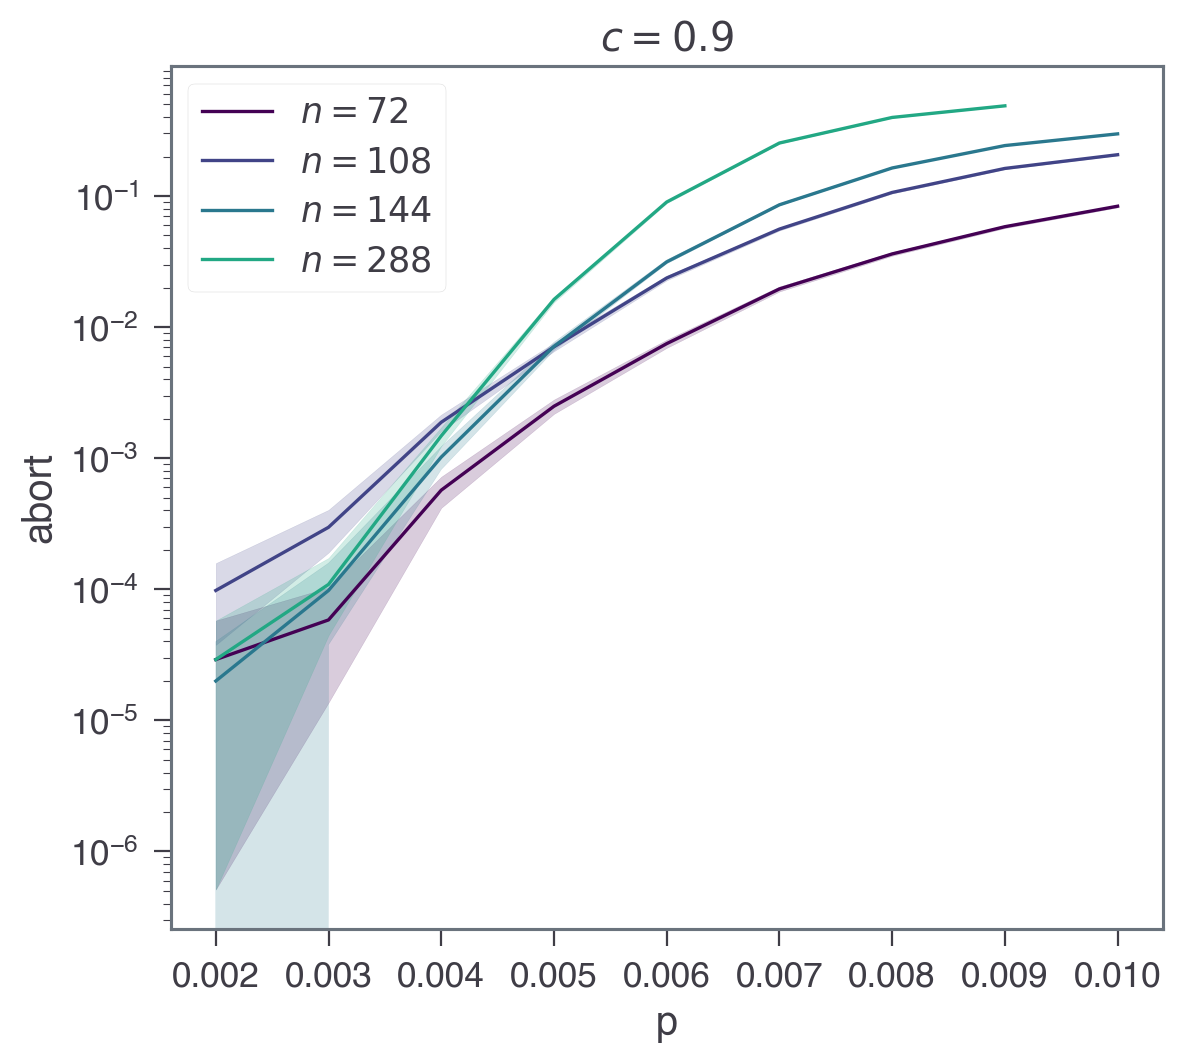

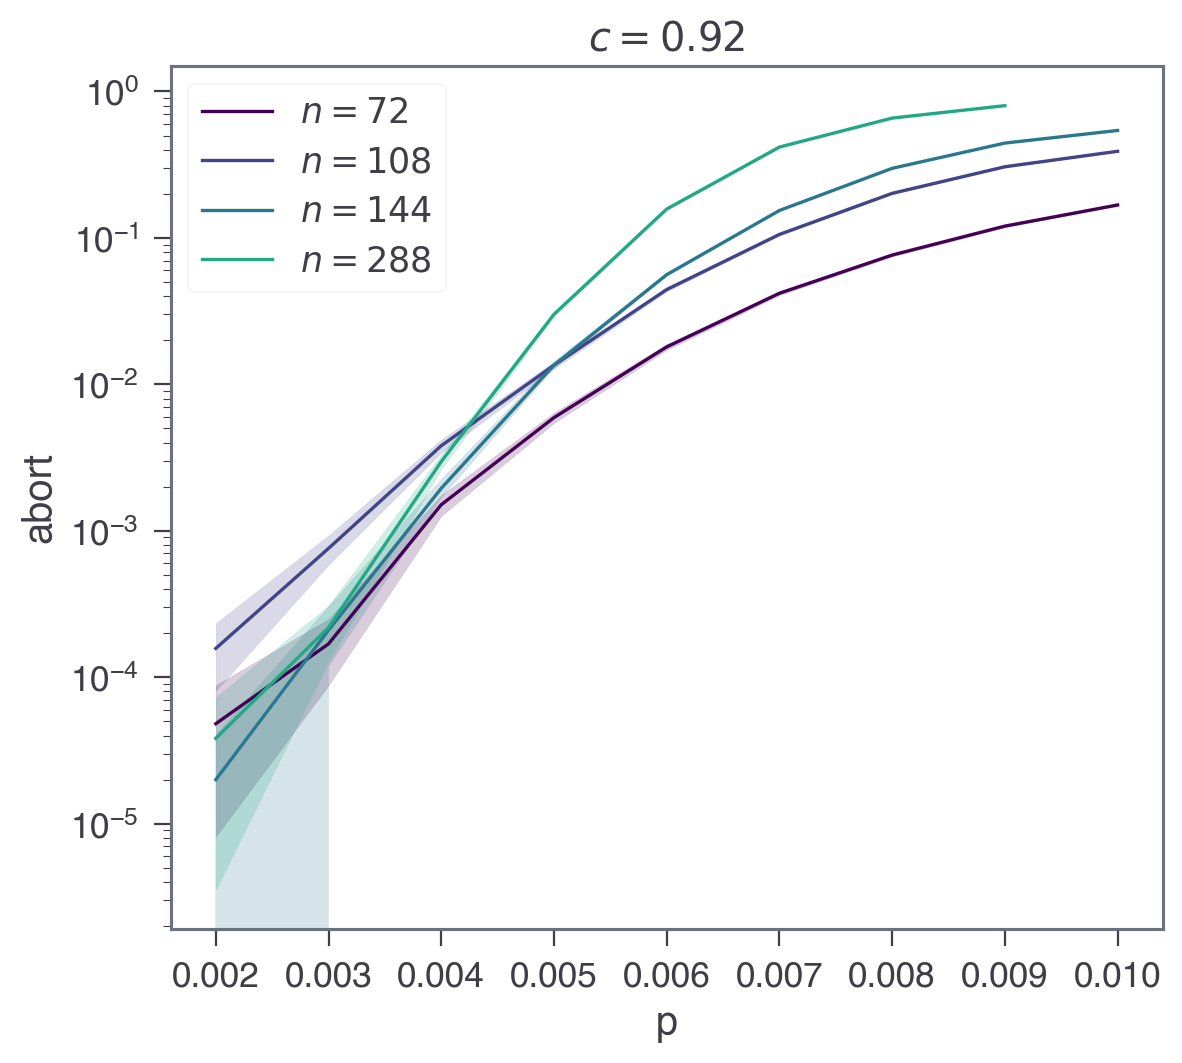

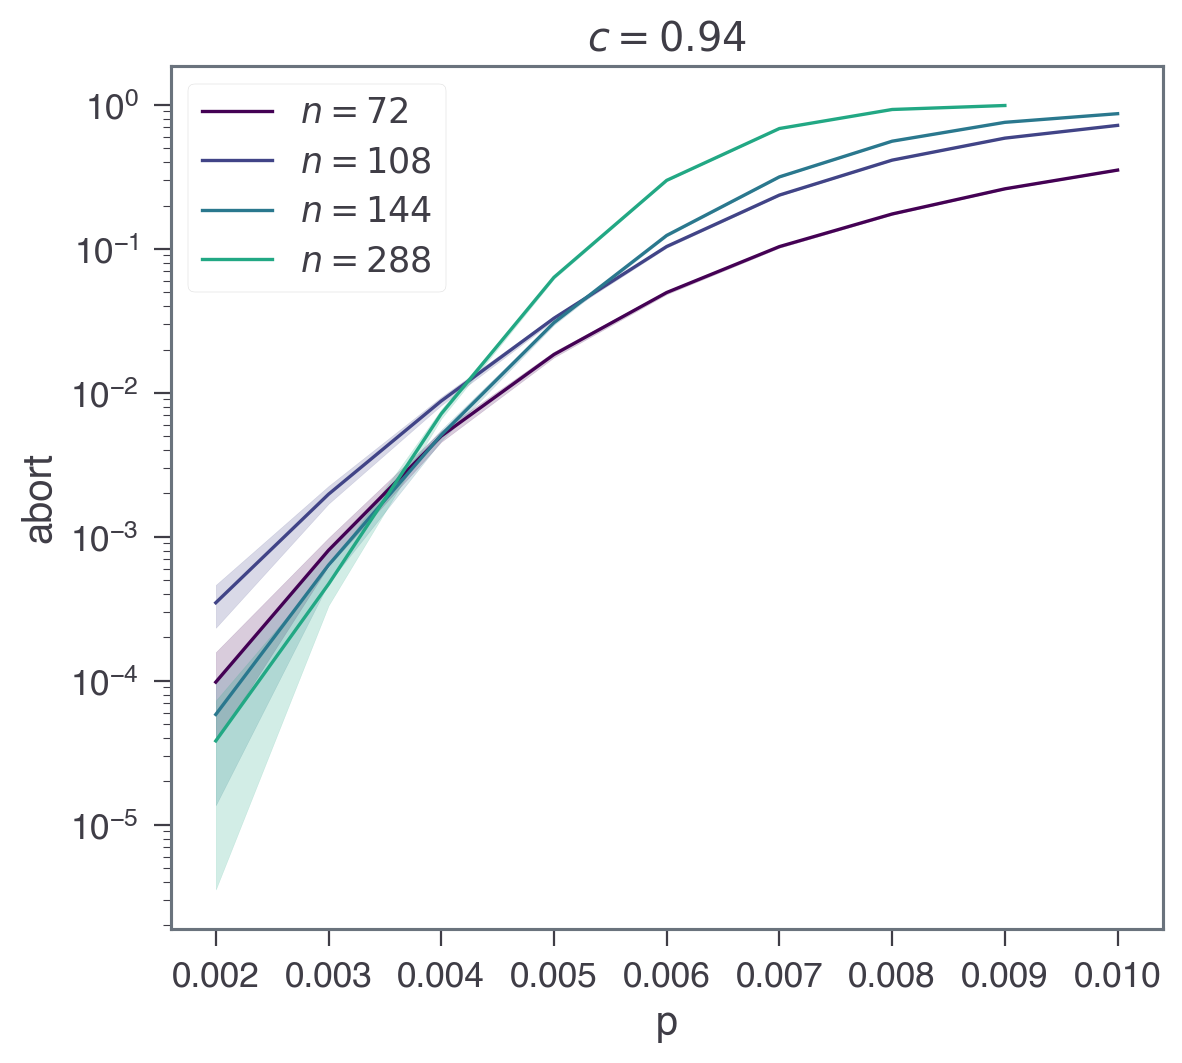

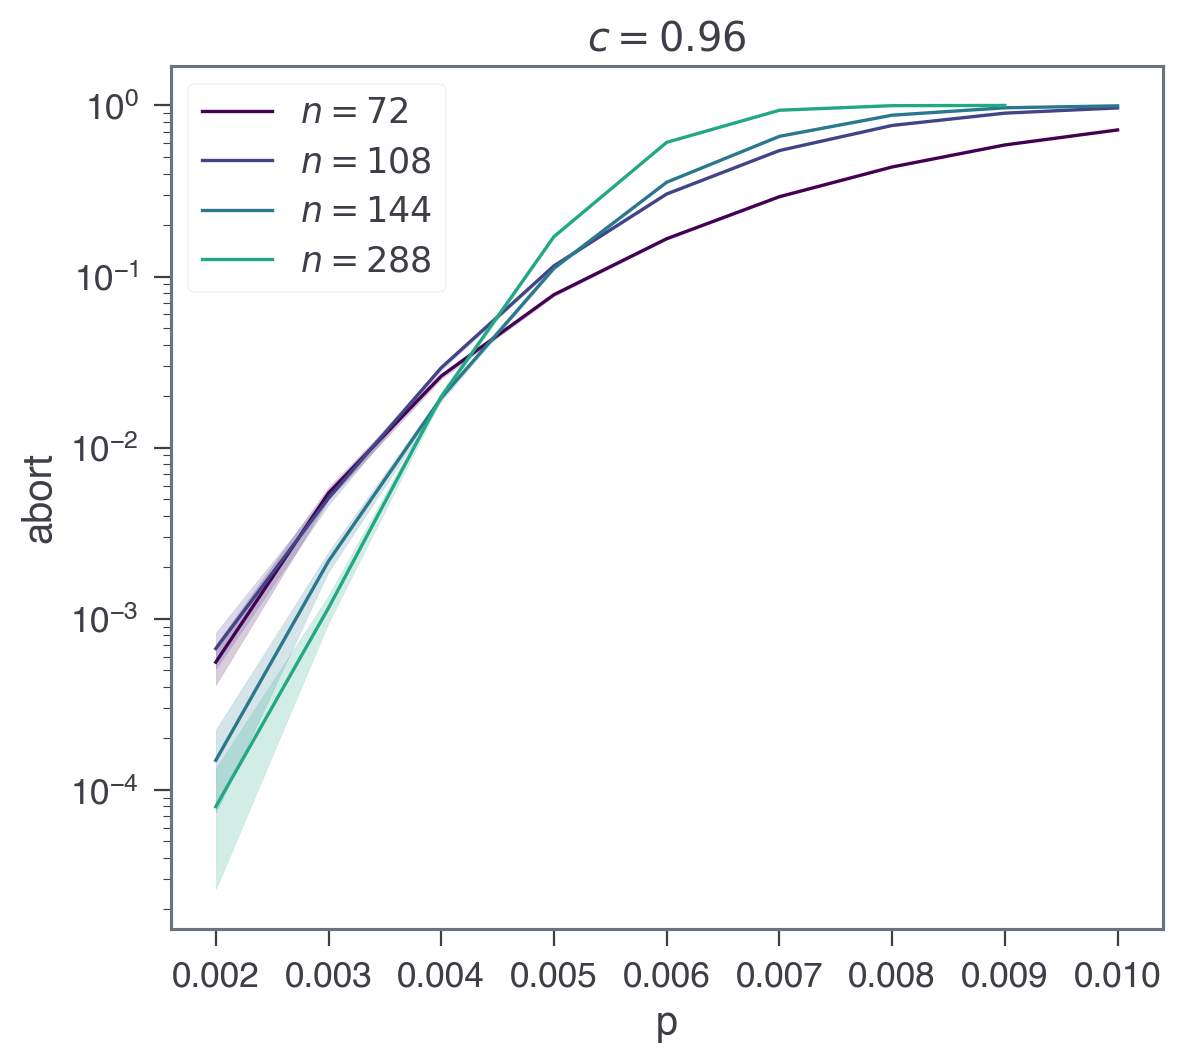

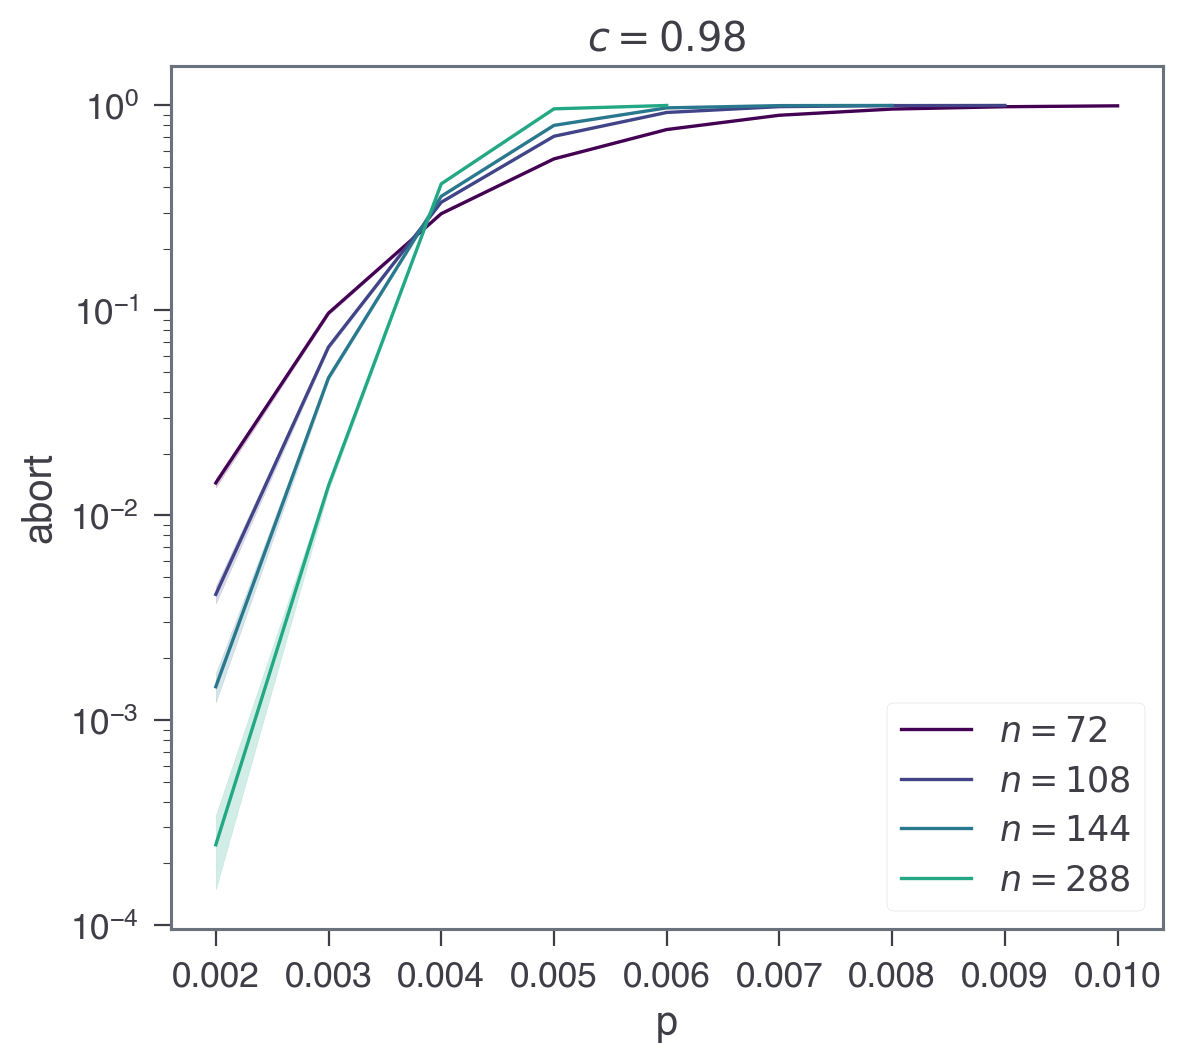

In [46]:
cmap = plt.cm.viridis
clist_plot = np.arange(0.9, 1, 0.02).round(decimals=6)
for c in clist_plot:
    for i_n, n in enumerate(nlist):
        color = cmap(i_n / len(nlist) * 0.8)
        df_partial = df_PS.loc[idx[n, :, c], :].reset_index()
        sns.lineplot(
            df_partial, x="p", y="abort", color=color, label=r"$n={}$".format(n)
        )
        plt.fill_between(
            x=df_partial["p"],
            y1=df_partial["abort_low"],
            y2=df_partial["abort_upp"],
            color=color,
            alpha=0.2,
        )
    plt.yscale("log")
    # plt.xscale('log')
    plt.legend()
    plt.title(r"$c={}$".format(c))
    plt.show()

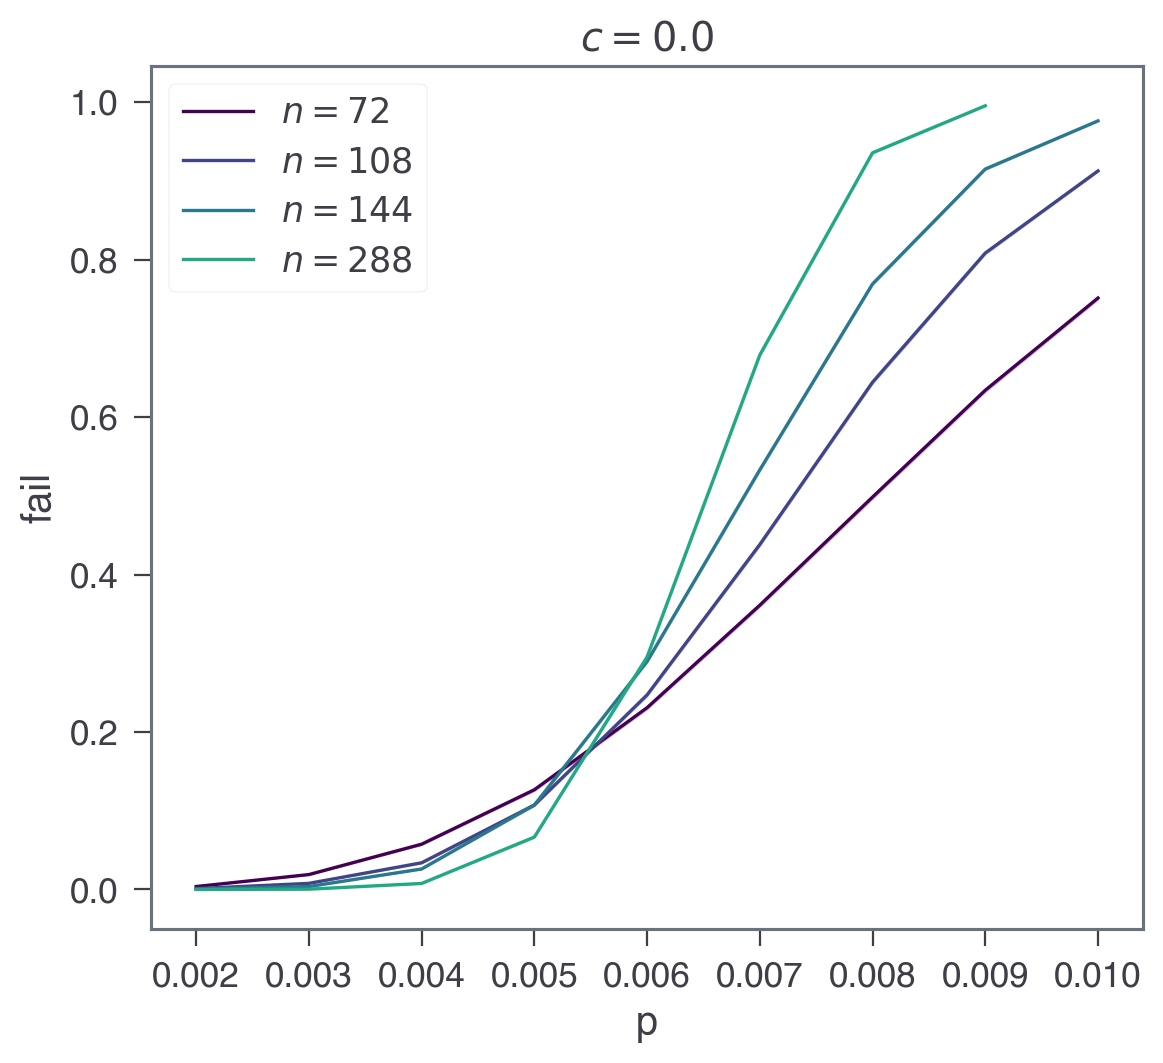

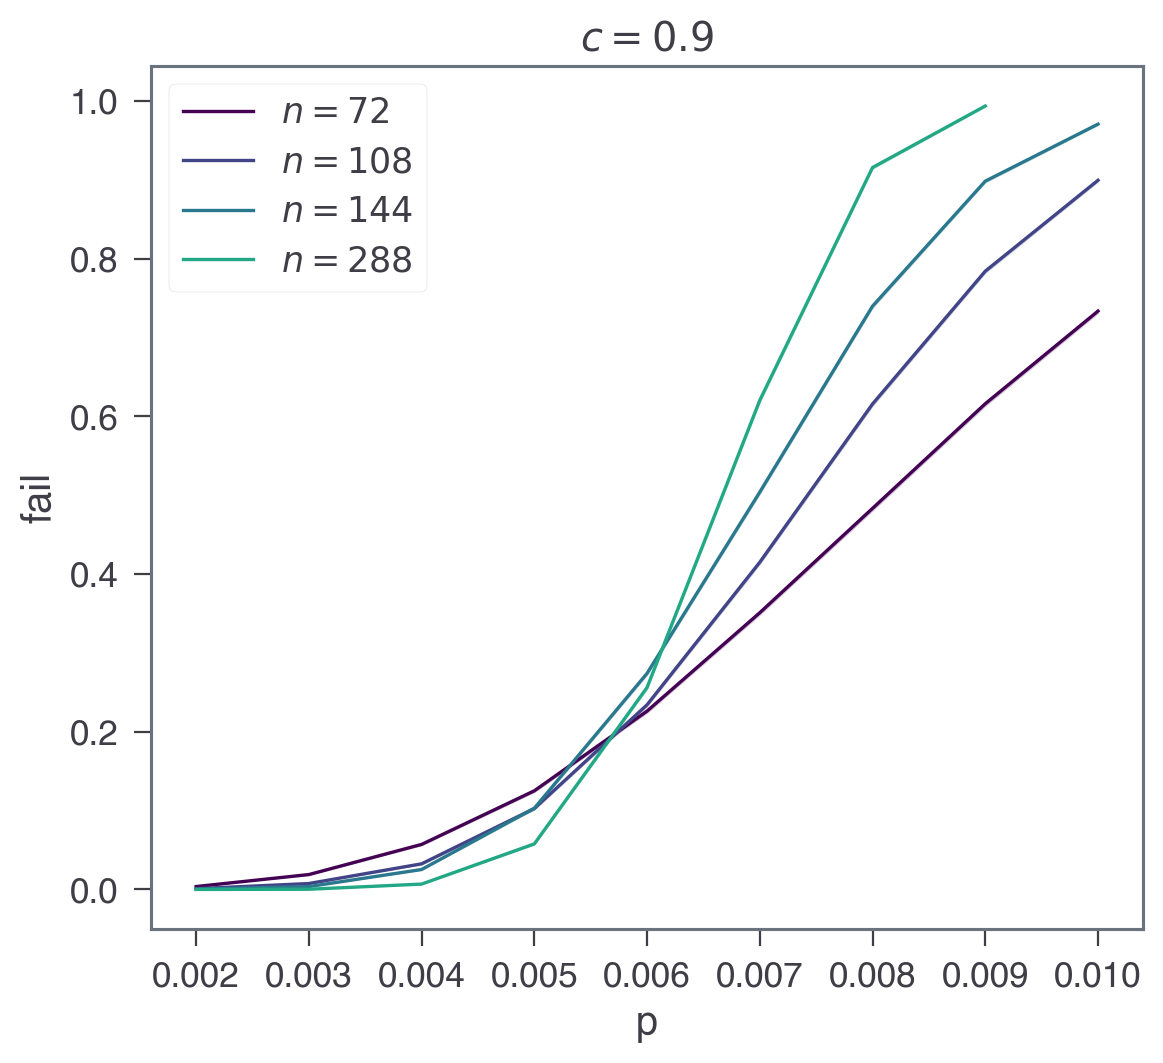

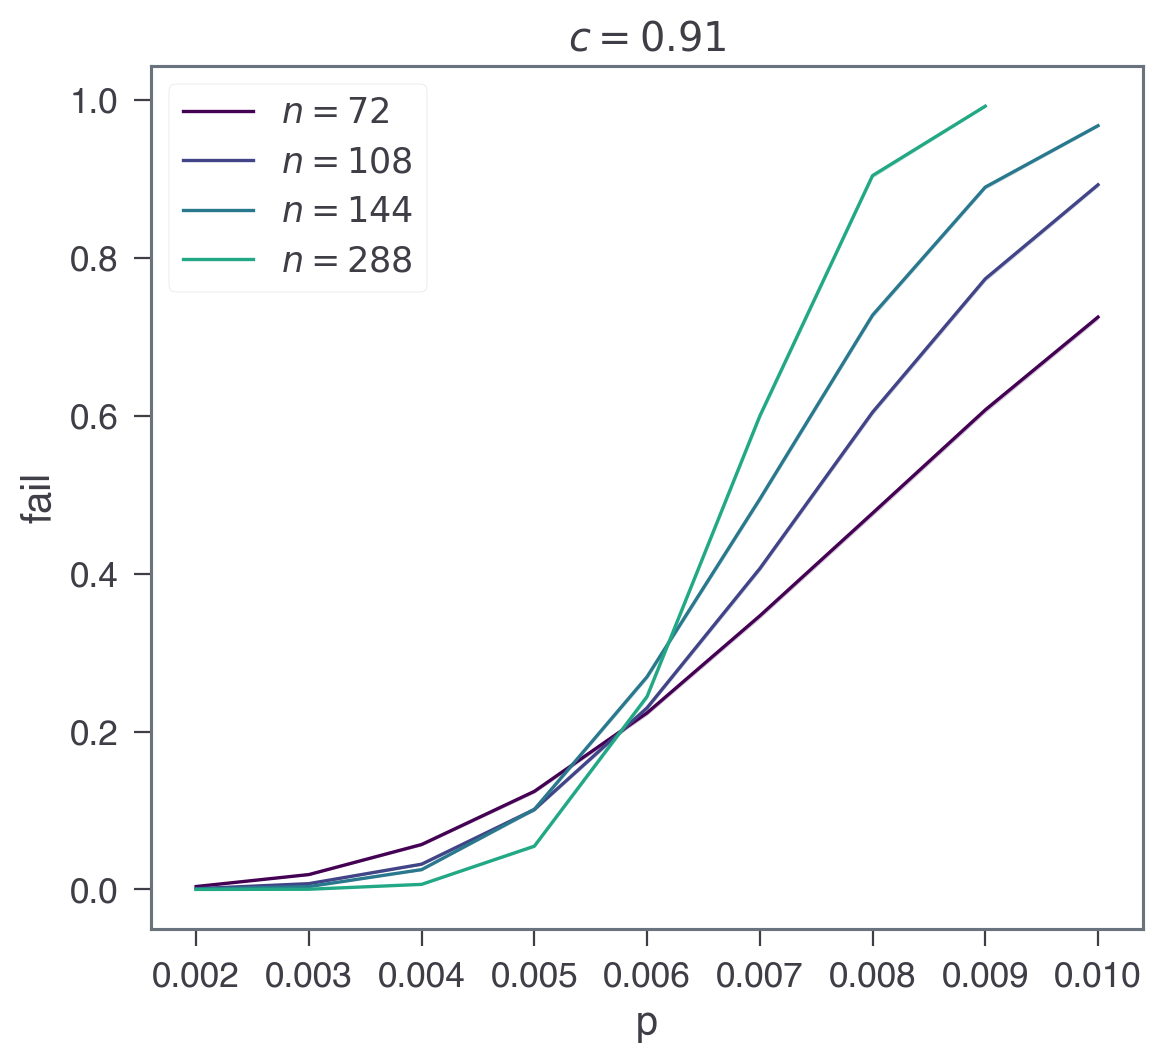

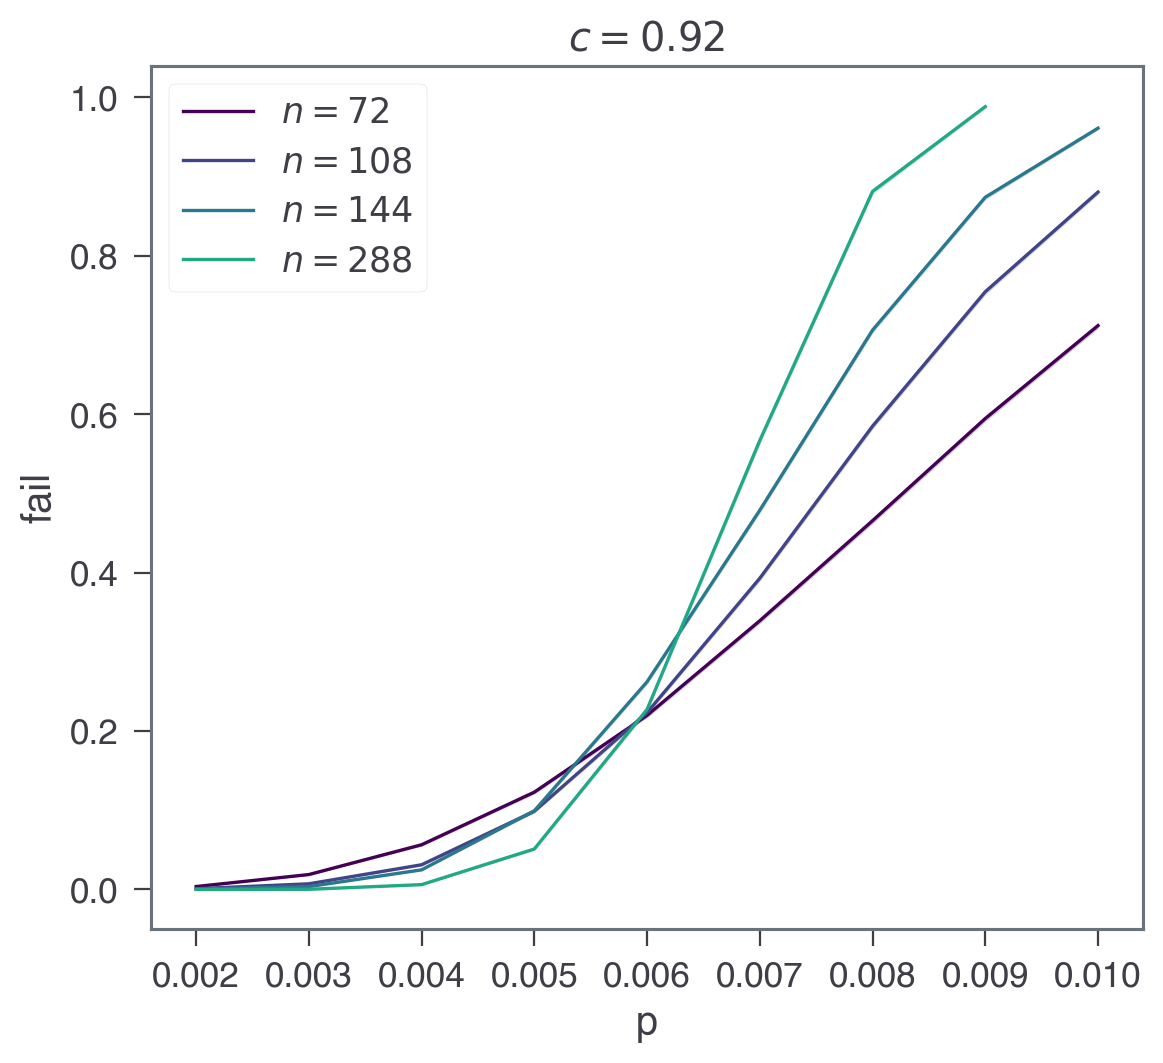

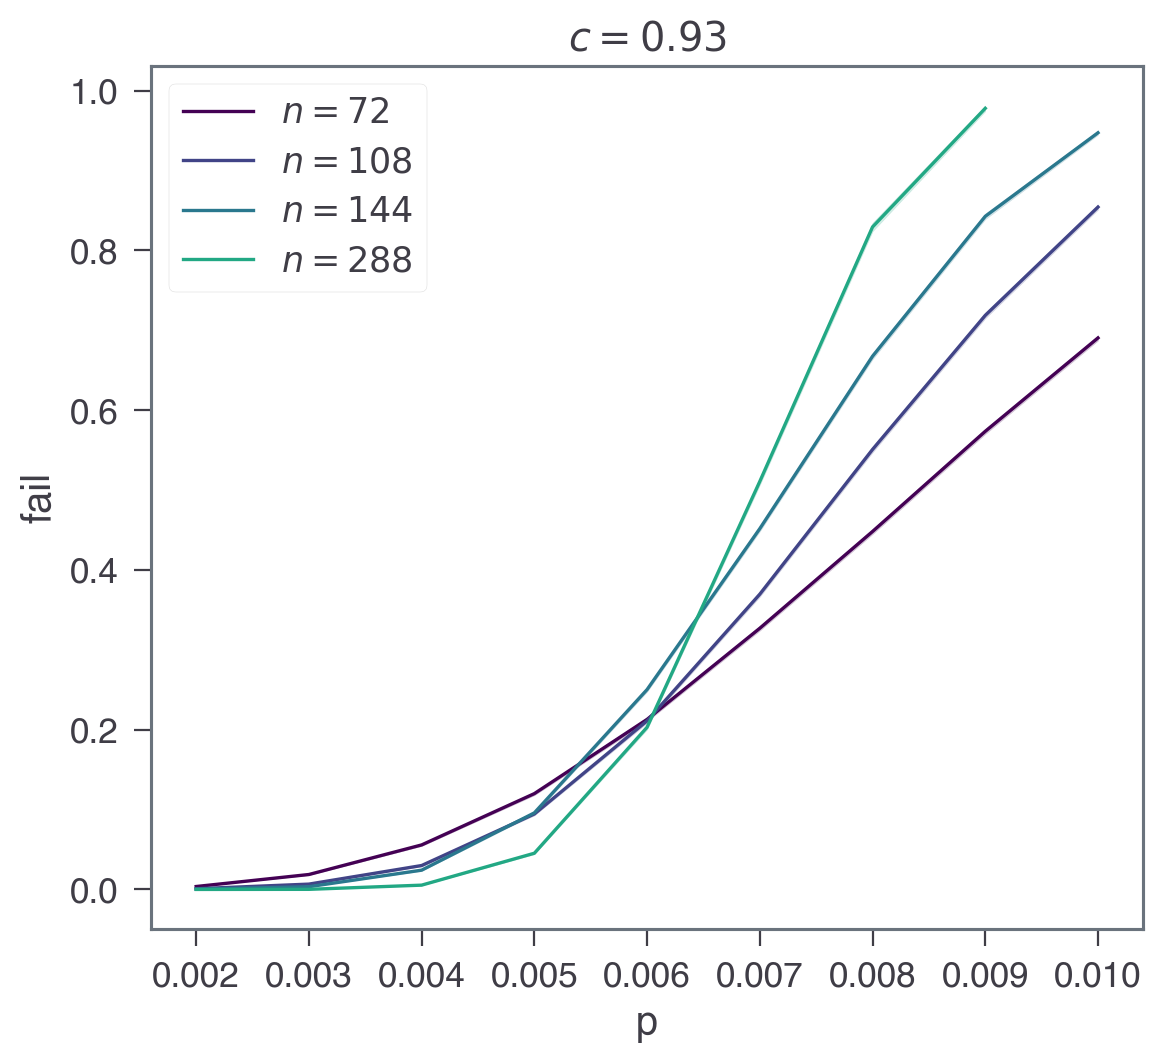

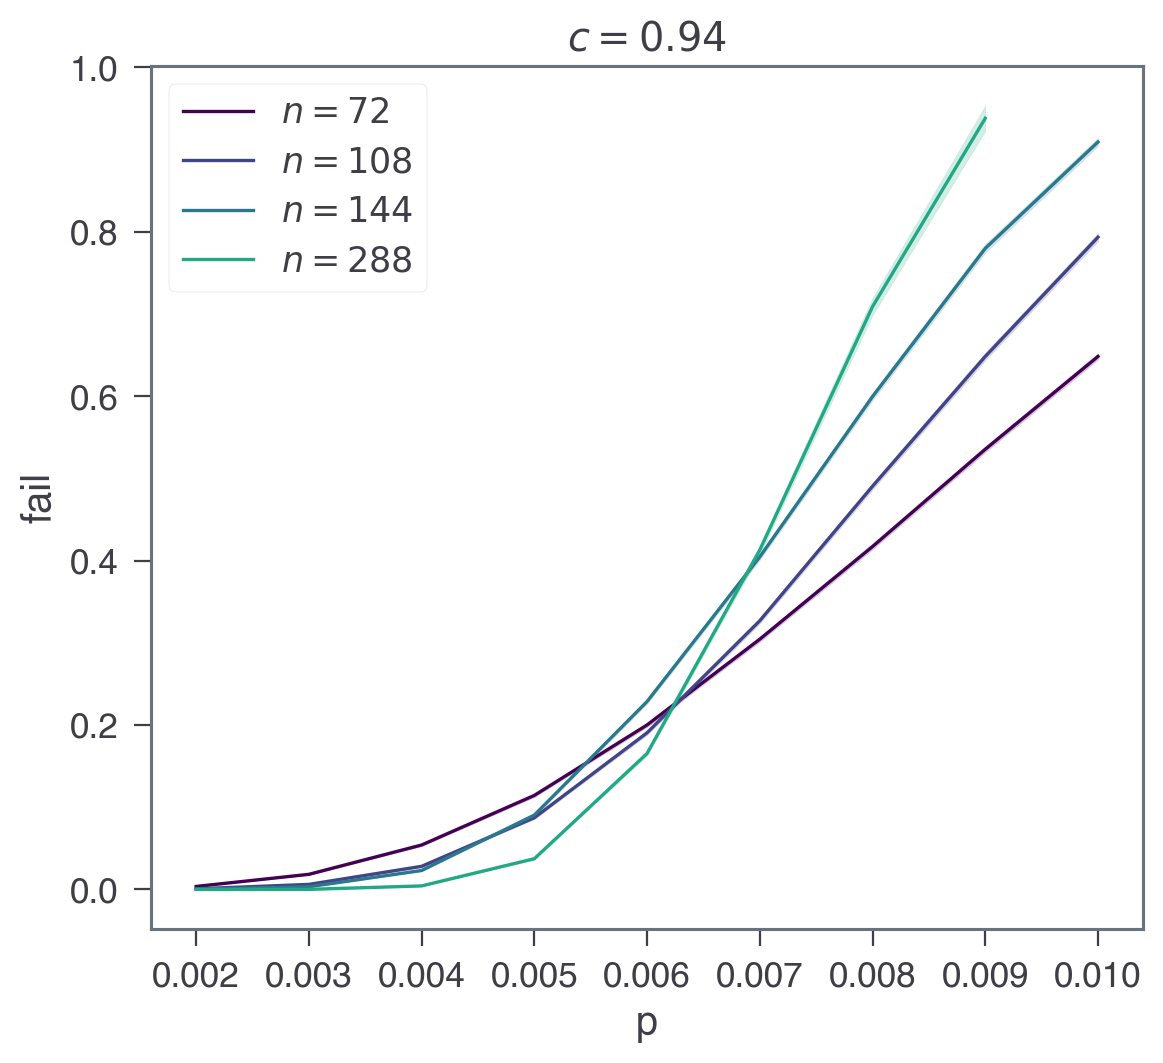

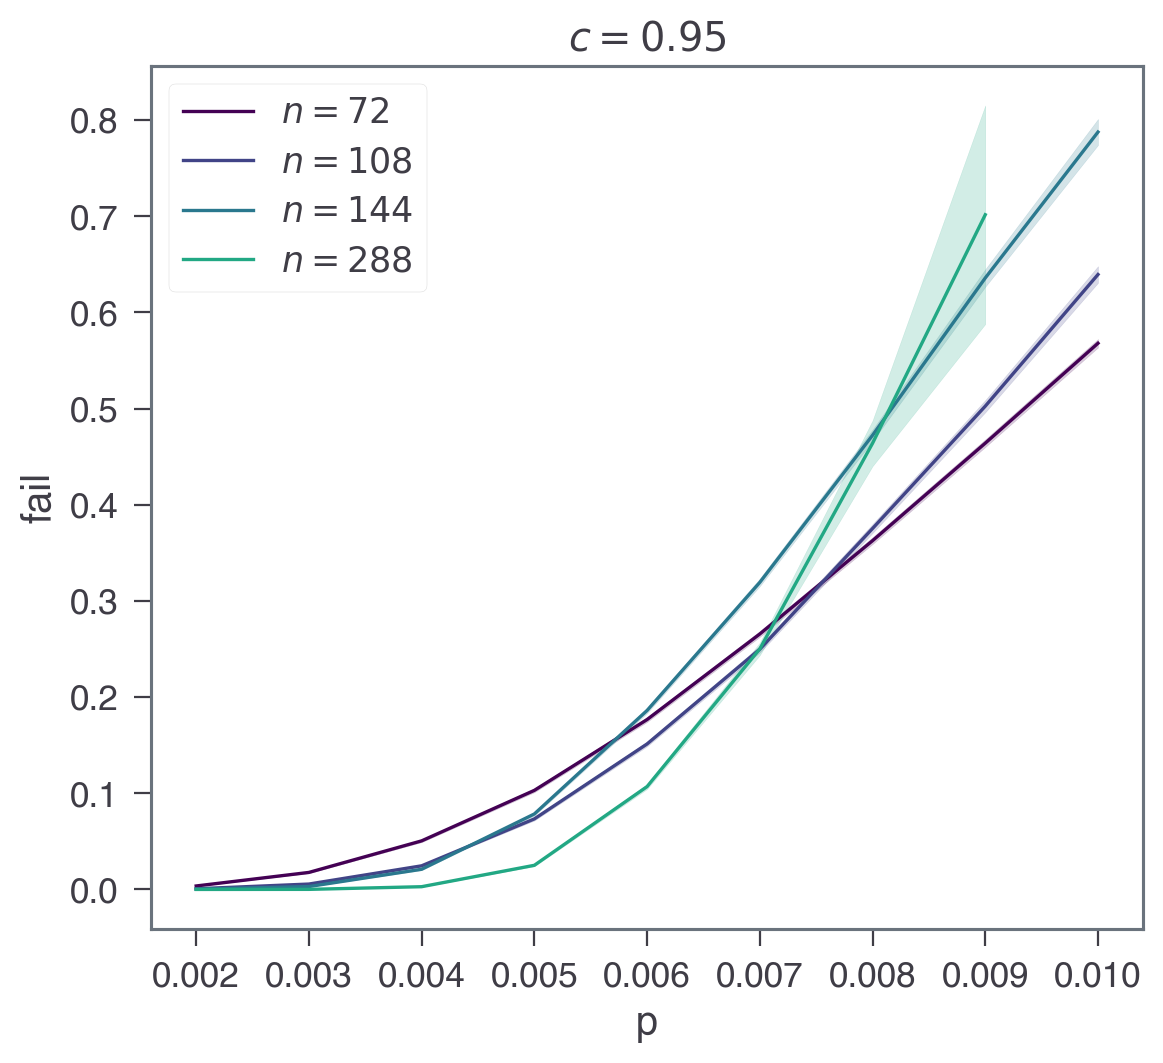

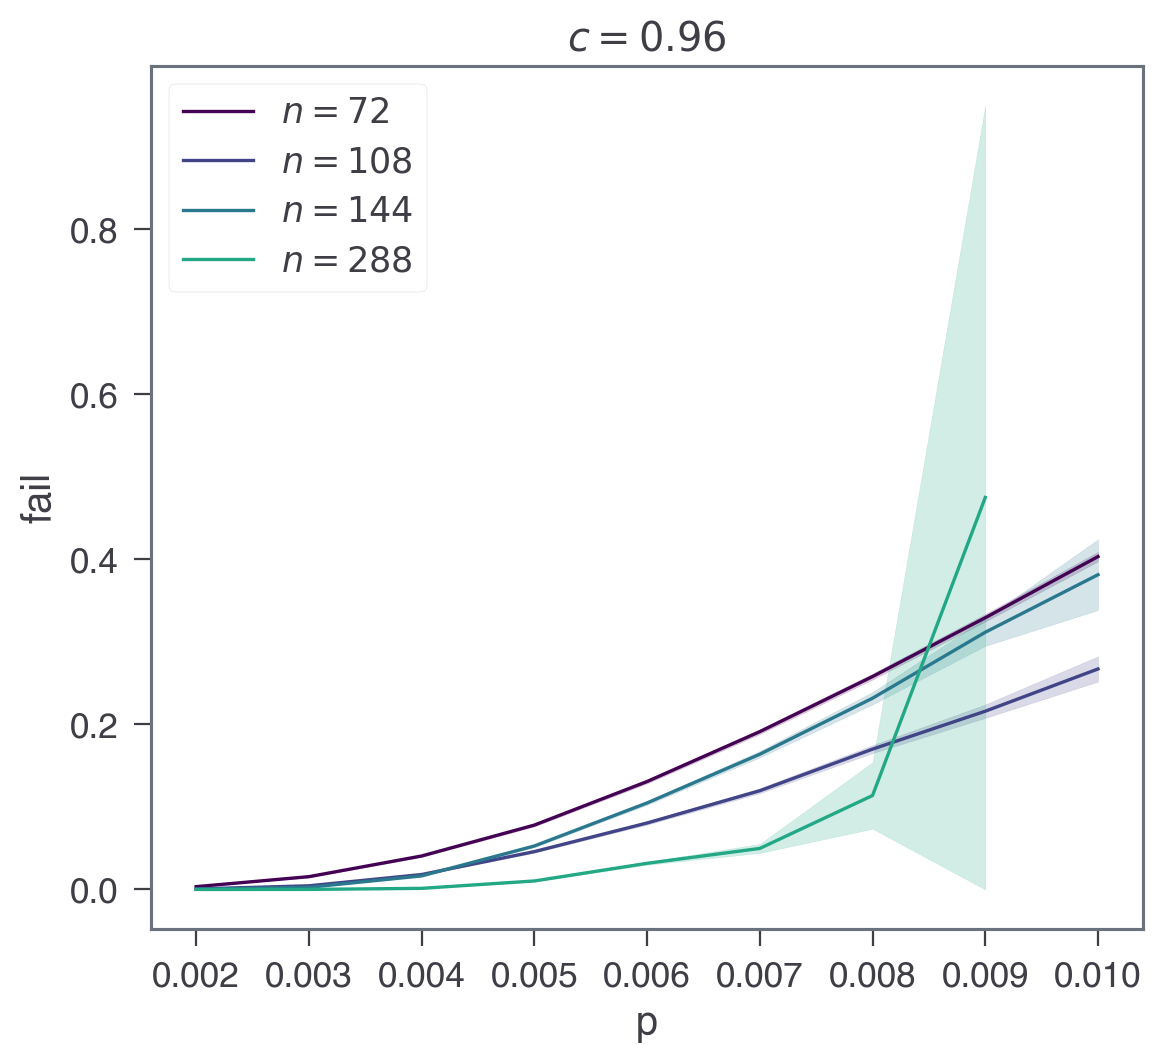

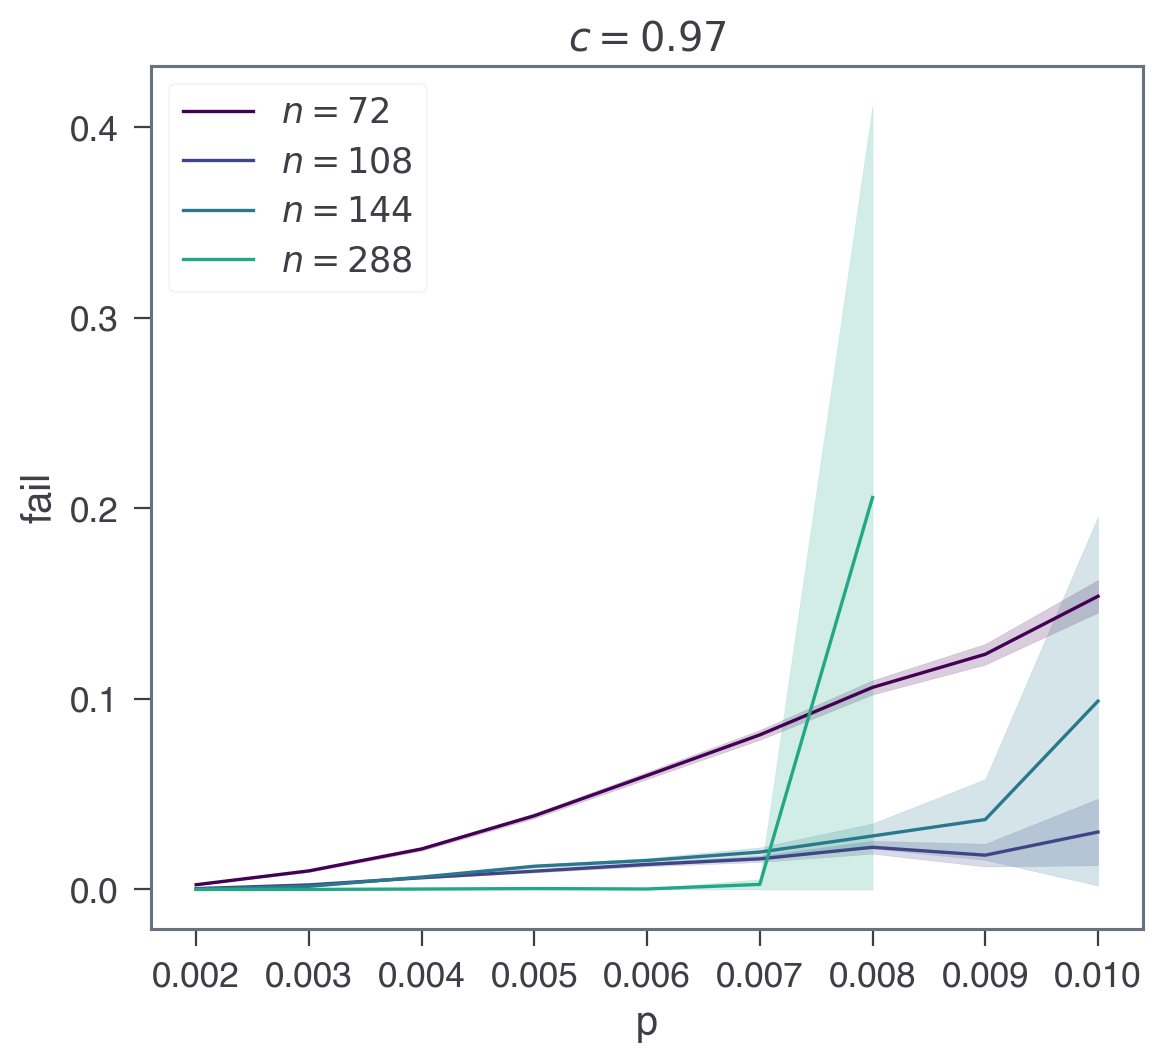

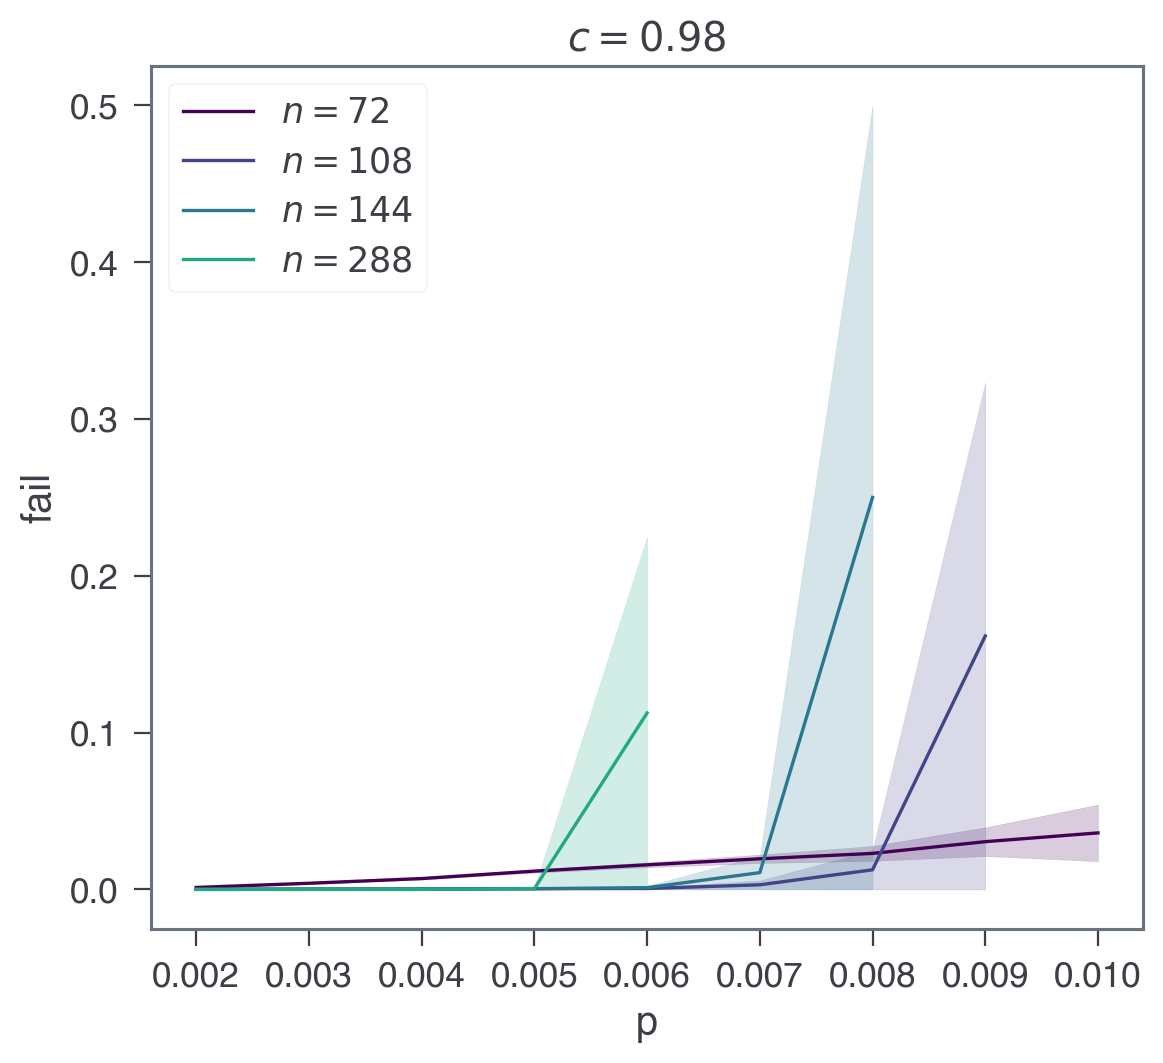

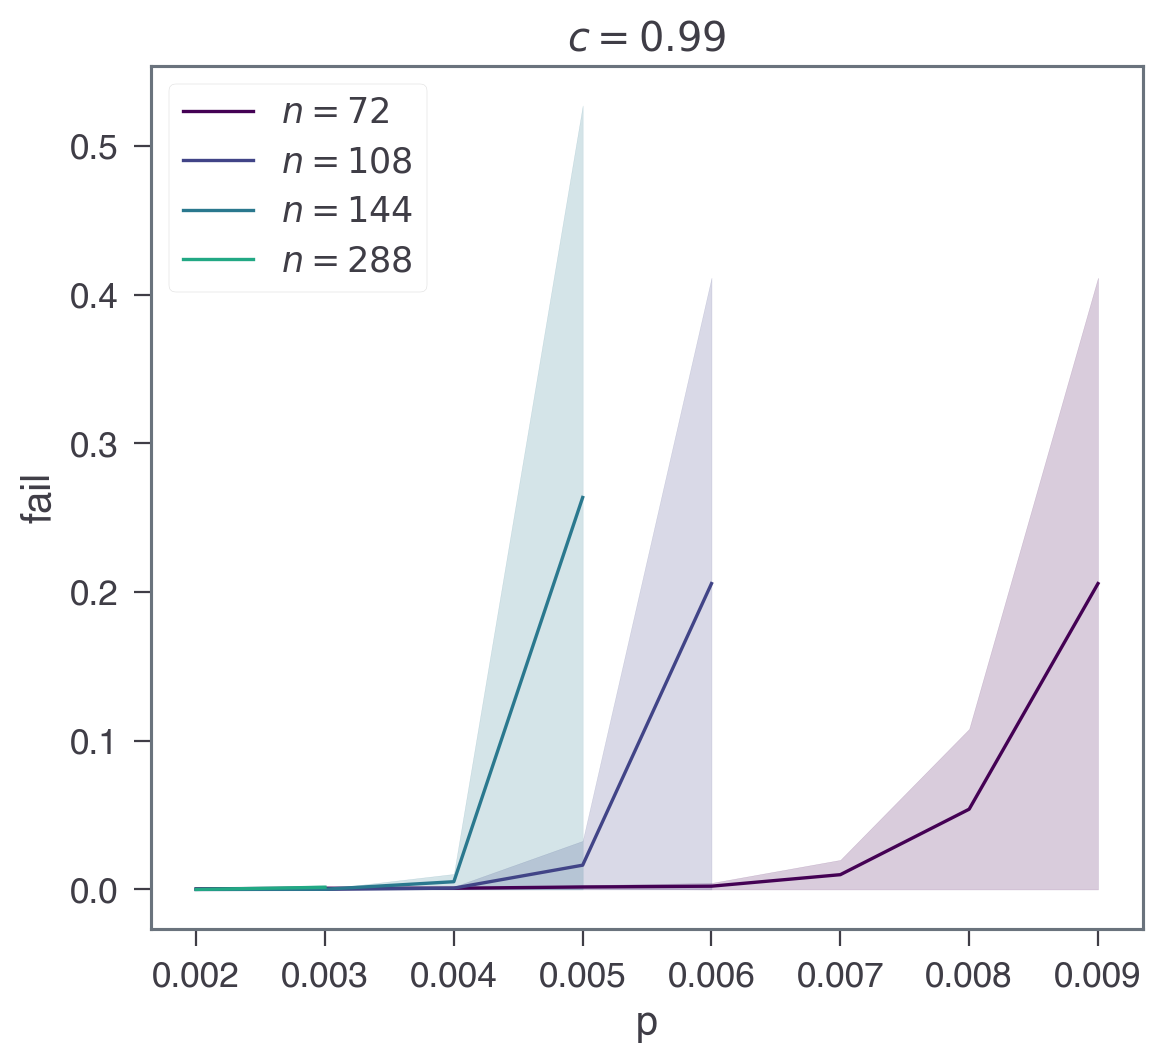

In [47]:
cmap = plt.cm.viridis
clist_plot = np.arange(0.9, 1, 0.01).round(decimals=6)
clist_plot = np.concatenate([np.array([0.0]), clist_plot])
for c in clist_plot:
    for i_n, n in enumerate(nlist):
        color = cmap(i_n / len(nlist) * 0.8)
        df_partial = df_PS.loc[idx[n, :, c], :].reset_index()
        sns.lineplot(
            df_partial, x="p", y="fail", color=color, label=r"$n={}$".format(n)
        )
        plt.fill_between(
            x=df_partial["p"],
            y1=df_partial["fail_low"],
            y2=df_partial["fail_upp"],
            color=color,
            alpha=0.2,
        )
    # plt.yscale('log')
    # plt.xscale('log')
    plt.legend()
    plt.title(r"$c={}$".format(c))
    plt.show()